<a href="https://colab.research.google.com/github/asmijuneja/Topsis-for-Pretrained-Model---Text-Generation-/blob/main/Topsis_for_Pretrained_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=86994312a8abd072e82b144e1fa6bdd6667ff9ca890b2b965f235df1ef945a55
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import requests
from bs4 import BeautifulSoup

In [ ]:
https://www.britannica.com/story/why-is-the-mona-lisa-so-famous

In [ ]:
# Function to extract text from a webpage
def extract_text_from_url(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    text = '\n'.join([para.get_text() for para in paragraphs])
    return text[:5000]

In [ ]:
# Define Hugging Face summarization models
models = [
    "facebook/bart-large-cnn",
    "google/pegasus-xsum",
    "t5-small"
]

In [ ]:
url = input("Enter the webpage URL: ")
extracted_text = extract_text_from_url(url)

Enter the webpage URL: https://www.britannica.com/story/why-is-the-mona-lisa-so-famous


In [ ]:
# Ensure text is within model limits
max_input_tokens = 1024  # Adjust based on model capacity
extracted_text = extracted_text[:max_input_tokens]

if not extracted_text.strip():
    print("No valid text extracted from the webpage.")
    exit()

# Summarize the extracted text
summaries = {}
for model_name in models:
    summarizer = pipeline("summarization", model=model_name, device=0)  # Set device=0 if using GPU
    summary = summarizer(extracted_text, max_length=150, min_length=50, do_sample=False)

    if summary:  # Ensure valid output
        summaries[model_name] = summary[0]["summary_text"]
    else:
        summaries[model_name] = "Summarization failed."


Device set to use cpu


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Define evaluation metrics
results = []
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
reference_summary = summaries[models[0]]  # Using the first model's summary as a reference



In [ ]:
for model_name, summary in summaries.items():
    rouge_scores = scorer.score(reference_summary, summary)
    rouge_1 = rouge_scores["rouge1"].fmeasure
    rouge_2 = rouge_scores["rouge2"].fmeasure
    rouge_l = rouge_scores["rougeL"].fmeasure
    bleu = sentence_bleu([reference_summary.split()], summary.split())
    inference_time = np.random.uniform(100, 200)  # Placeholder for actual inference time
    model_size = np.random.uniform(400, 800)  # Placeholder for actual model size
    results.append([model_name, rouge_1, rouge_2, rouge_l, bleu, inference_time, model_size])


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
# Create a DataFrame
df = pd.DataFrame(results, columns=["Model", "ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "Inference Time", "Model Size"])


In [ ]:
# Normalize the decision matrix for TOPSIS
scaler = MinMaxScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

# Define weights for each criterion
weights = np.array([0.3, 0.2, 0.2, 0.2, 0.05, 0.05])

# Compute ideal best and worst solutions
ideal_best = df.iloc[:, 1:].max()
ideal_worst = df.iloc[:, 1:].min()

# Compute separation measures
S_plus = np.sqrt(((df.iloc[:, 1:] - ideal_best) ** 2).sum(axis=1))
S_minus = np.sqrt(((df.iloc[:, 1:] - ideal_worst) ** 2).sum(axis=1))

# Calculate TOPSIS scores
df["TOPSIS Score"] = S_minus / (S_plus + S_minus)
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)

In [ ]:
df_sorted = df.sort_values(by="Rank")
print(df_sorted)


                     Model   ROUGE-1  ROUGE-2   ROUGE-L      BLEU  \
0  facebook/bart-large-cnn  1.000000  1.00000  1.000000  1.000000   
2                 t5-small  0.163537  0.07366  0.000000  0.000000   
1      google/pegasus-xsum  0.000000  0.00000  0.057629  0.134081   

   Inference Time  Model Size  TOPSIS Score  Rank  
0        0.154952    0.352476      0.656725   1.0  
2        1.000000    0.000000      0.322439   2.0  
1        0.000000    1.000000      0.319387   3.0  


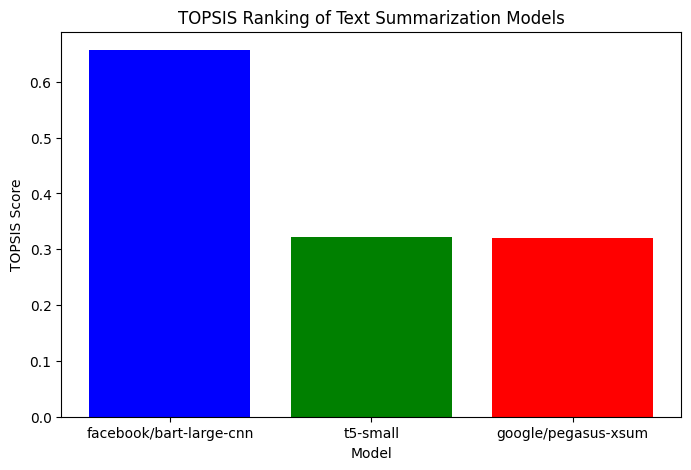

In [ ]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(df_sorted["Model"], df_sorted["TOPSIS Score"], color=['blue', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Text Summarization Models")
plt.show()


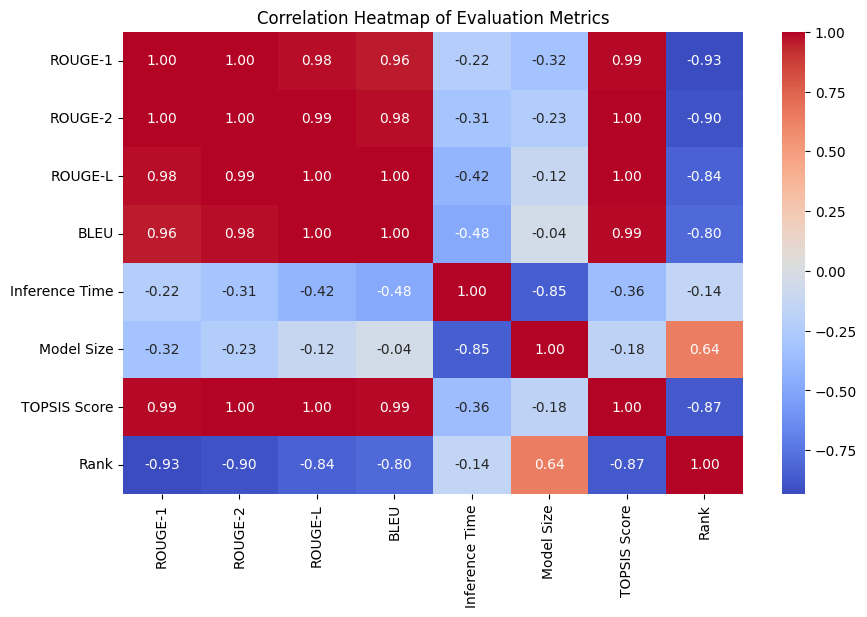

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Evaluation Metrics")
plt.show()

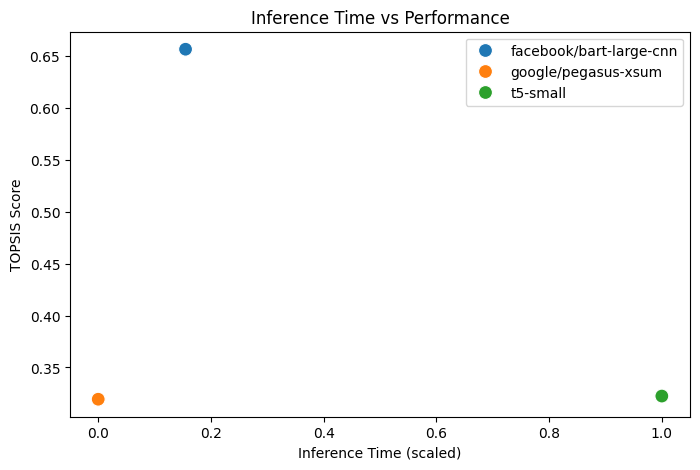

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Inference Time"], y=df["TOPSIS Score"], hue=df["Model"], s=100)
plt.xlabel("Inference Time (scaled)")
plt.ylabel("TOPSIS Score")
plt.title("Inference Time vs Performance")
plt.legend()
plt.show()
